In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
class Agent:
    def __init__(self, initial_theta, learning_rate=0.01):
        self.theta = initial_theta
        self.learning_rate = learning_rate
        self.history = []

    def update_model(self, y_true, y_pred):
        loss = self.compute_loss(y_true, y_pred)
        self.history.append((y_true, y_pred, loss))
        self.theta -= self.learning_rate * self.compute_gradient(y_true, y_pred)
        return loss

    def compute_loss(self, y_true, y_pred):
        return 0.5 * (y_true - y_pred) ** 2

    def compute_gradient(self, y_true, y_pred):
        return -(y_true - y_pred)

    def predict(self, x):
        return np.dot(x, self.theta)

    def simple_mean_forecast(self, t):
        if t == 0:
            return 0
        return np.mean([y_true for y_true, _, _ in self.history[:t]])

    def moving_average_forecast(self, t, M):
        if t == 0:
            return 0
        start = max(0, t - M)
        return np.mean([y_true for y_true, _, _ in self.history[start:t]])

    def weighted_moving_average_forecast(self, t, weights):
        if t == 0:
            return 0
        M = len(weights)
        start = max(0, t - M)
        relevant_hist = self.history[start:t]
        weighted_sum = sum(weights[i] * relevant_hist[i][0] for i in range(len(relevant_hist)))
        return weighted_sum / sum(weights[:len(relevant_hist)])

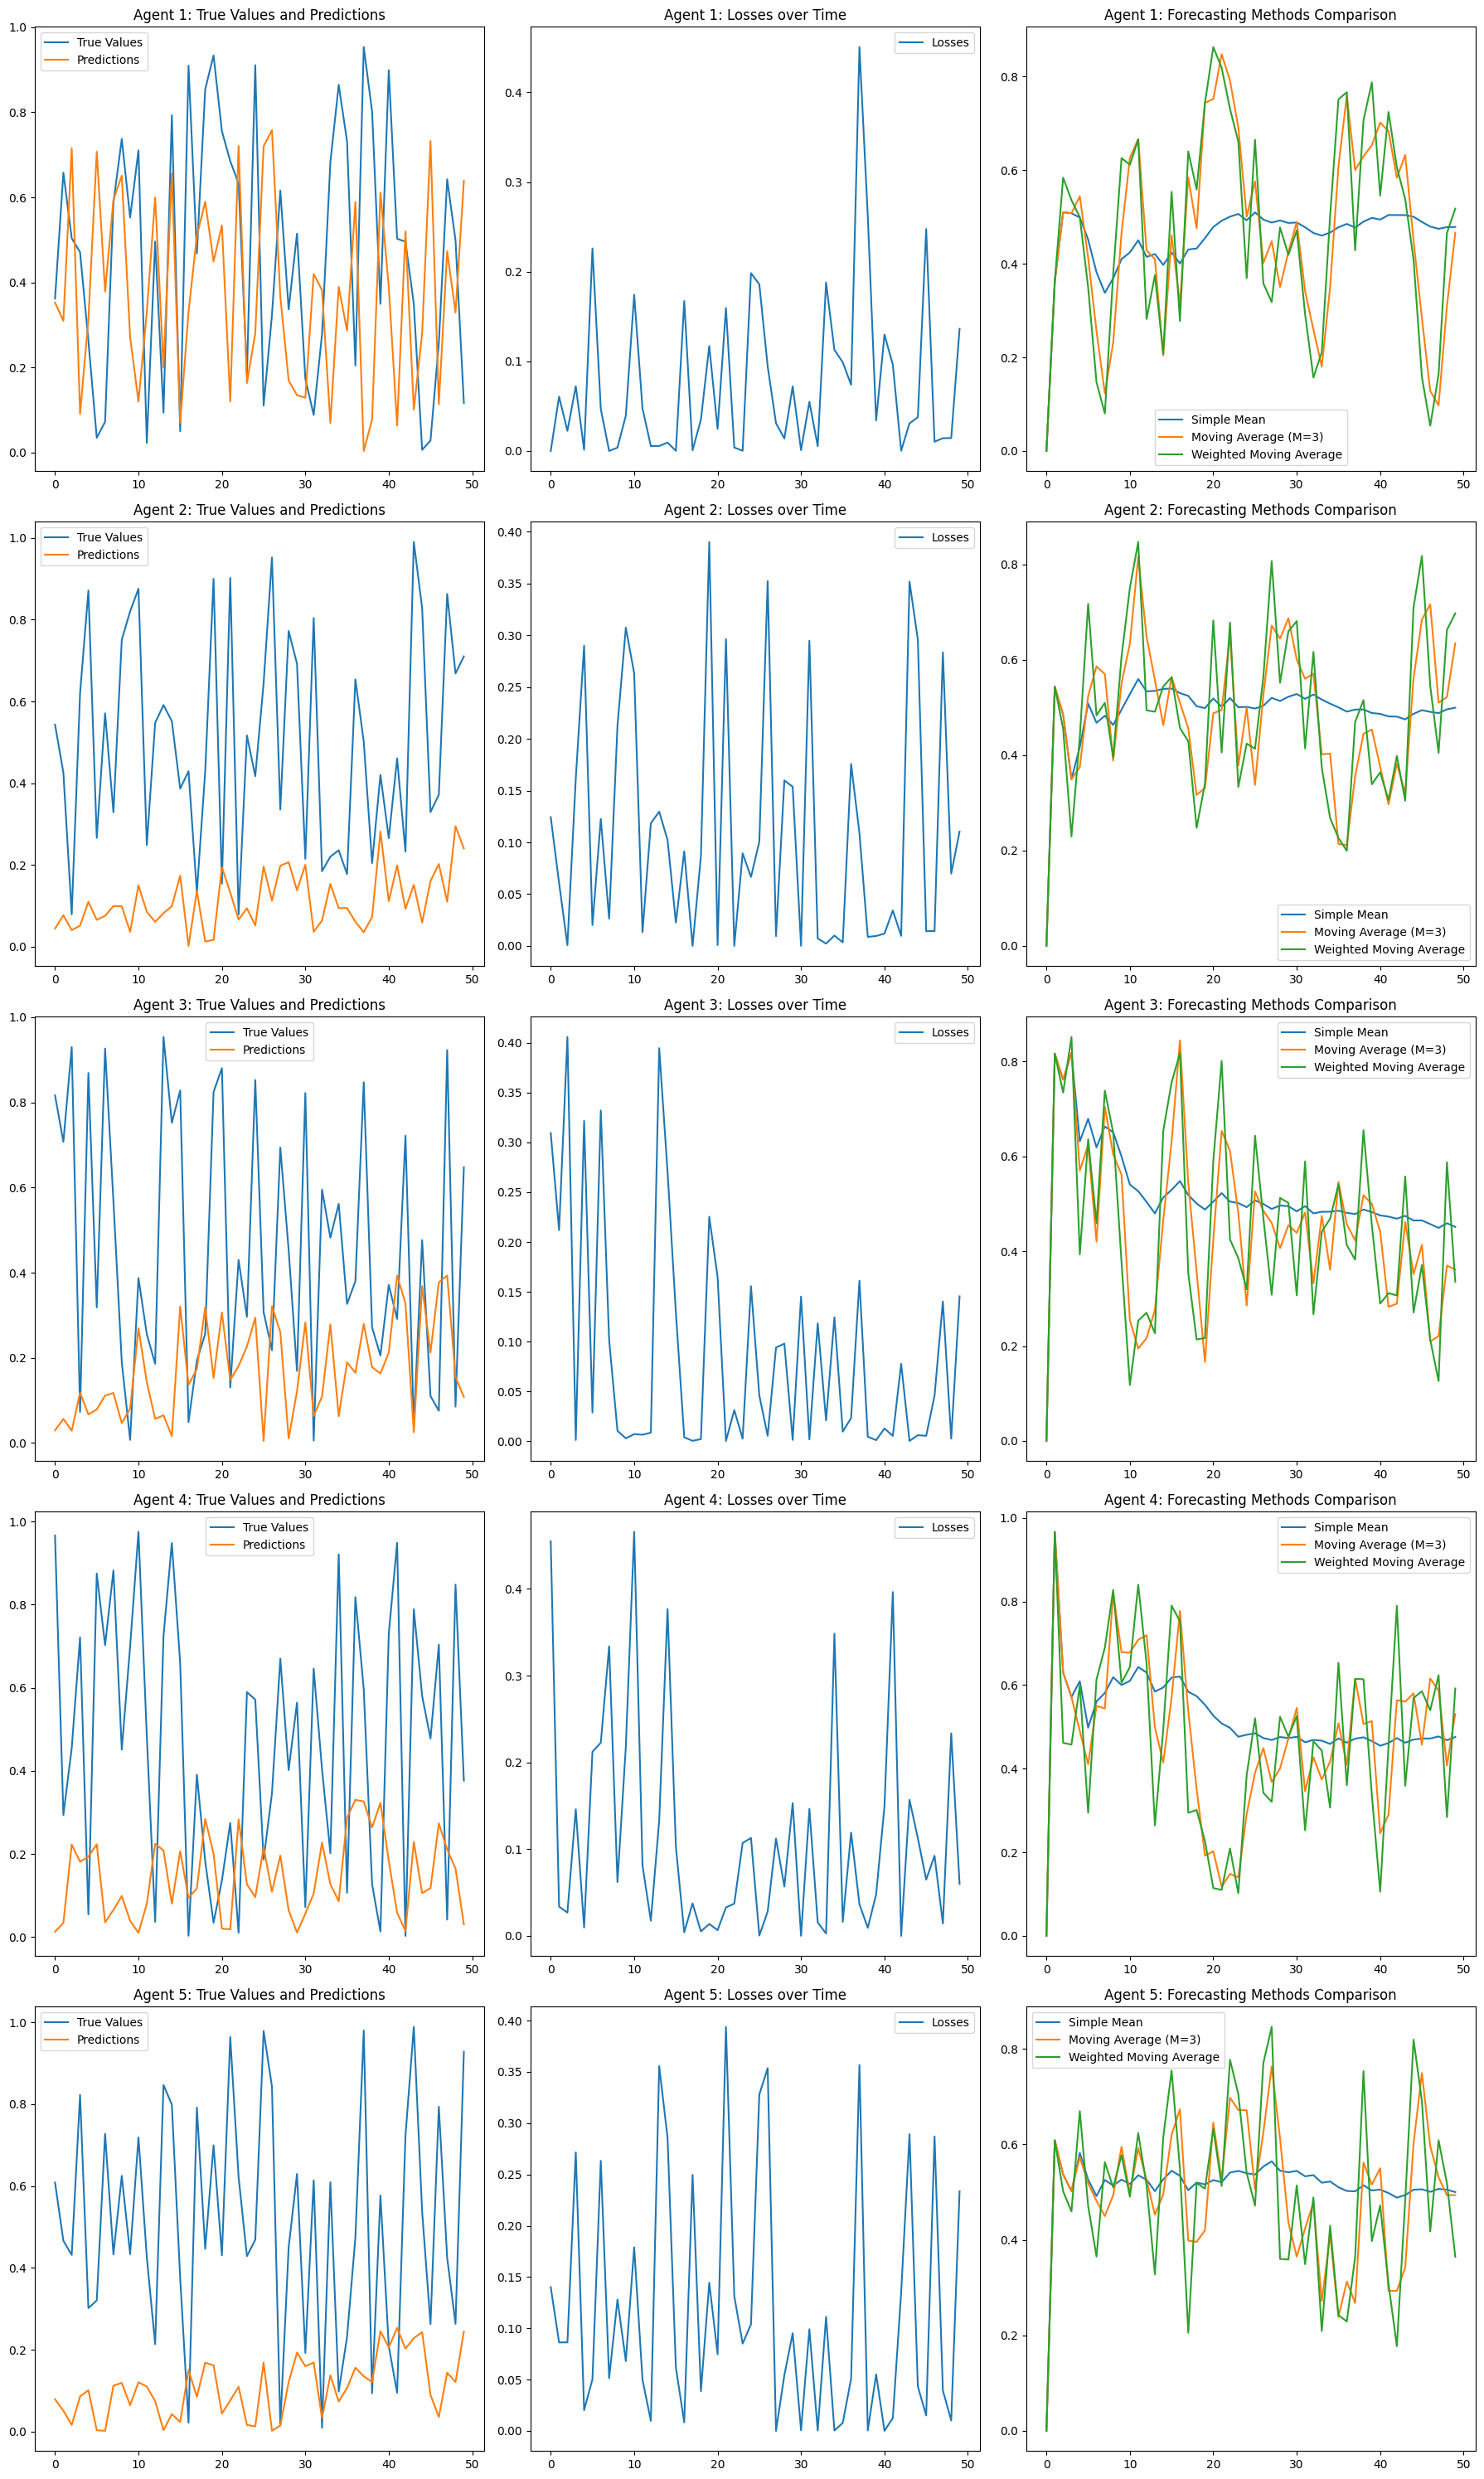

In [6]:
N = 5  # Number of agents
T = 50  # Number of time periods
agents = [Agent(initial_theta=np.random.rand(), learning_rate=0.01) for _ in range(N)]
for t in range(T):
    for agent in agents:
        x_t = np.random.rand()  # Example feature vector
        y_true = np.random.rand()  # Example true value
        y_pred = agent.predict(x_t)
        # Update agent's model
        loss = agent.update_model(y_true, y_pred)
        # Different forecasting methods
        simple_mean = agent.simple_mean_forecast(t)
        moving_avg = agent.moving_average_forecast(t, M=3)
        weights = [0.1, 0.3, 0.6]
        weighted_moving_avg = agent.weighted_moving_average_forecast(t, weights)
# Plotting results
fig, axs = plt.subplots(N, 3, figsize=(18, 6 * N))

for i, agent in enumerate(agents):
    y_trues = [y_true for y_true, _, _ in agent.history]
    y_preds = [y_pred for _, y_pred, _ in agent.history]
    losses = [loss for _, _, loss in agent.history]
    
    times = range(T)
    
    # Plot true values and predictions
    axs[i, 0].plot(times, y_trues, label='True Values')
    axs[i, 0].plot(times, y_preds, label='Predictions')
    axs[i, 0].set_title(f'Agent {i+1}: True Values and Predictions')
    axs[i, 0].legend()
    
    # Plot losses
    axs[i, 1].plot(times, losses, label='Losses')
    axs[i, 1].set_title(f'Agent {i+1}: Losses over Time')
    axs[i, 1].legend()
    # Compare forecasting methods
    simple_means = [agent.simple_mean_forecast(t) for t in times]
    moving_avgs = [agent.moving_average_forecast(t, M=3) for t in times]
    weighted_moving_avgs = [agent.weighted_moving_average_forecast(t, weights) for t in times]
    
    axs[i, 2].plot(times, simple_means, label='Simple Mean')
    axs[i, 2].plot(times, moving_avgs, label='Moving Average (M=3)')
    axs[i, 2].plot(times, weighted_moving_avgs, label='Weighted Moving Average')
    axs[i, 2].set_title(f'Agent {i+1}: Forecasting Methods Comparison')
    axs[i, 2].legend()

plt.tight_layout()
plt.show()

In [7]:
class RPSAgent:
    def __init__(self, initial_probs, learning_rate=0.01):
        self.probs = np.array(initial_probs)
        self.learning_rate = learning_rate
        self.history = []

    def select_action(self):
        return np.random.choice([0, 1, 2], p=self.probs)

    def update_strategy(self, opponent_action, my_action):
        payoff_matrix = np.array([[ 0, -1,  1],
                                  [ 1,  0, -1],
                                  [-1,  1,  0]])

        payoff = payoff_matrix[my_action, opponent_action]
        self.history.append((my_action, opponent_action, payoff))

        grad = -payoff_matrix[:, opponent_action]
        self.probs = self.probs + self.learning_rate * grad
        self.probs = np.clip(self.probs, 0, 1)
        self.probs /= self.probs.sum()

    def get_history(self):
        return np.array(self.history)


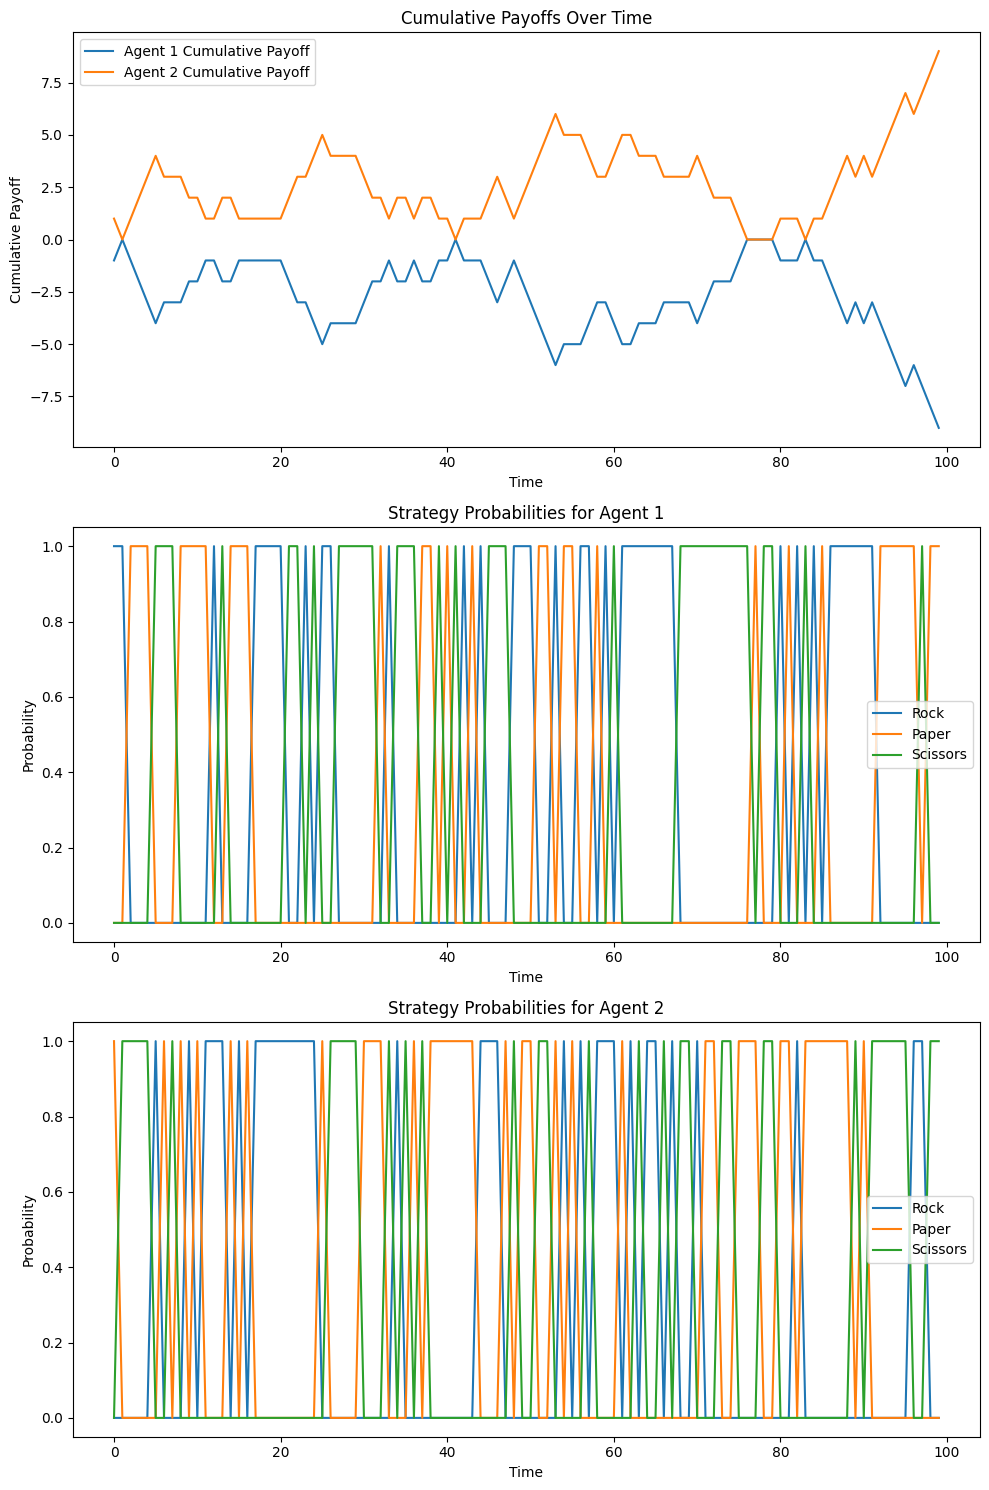

In [8]:
# Parameters
initial_probs = [1/3, 1/3, 1/3]
learning_rate = 0.1
T = 100  # Number of time periods

# Initialize agents
agent1 = RPSAgent(initial_probs, learning_rate)
agent2 = RPSAgent(initial_probs, learning_rate)

# Play the game for T periods
for t in range(T):
    action1 = agent1.select_action()
    action2 = agent2.select_action()
    agent1.update_strategy(action2, action1)
    agent2.update_strategy(action1, action2)

# Retrieve history
history1 = agent1.get_history()
history2 = agent2.get_history()

# Plotting results
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot payoffs
payoffs1 = history1[:, 2]
payoffs2 = history2[:, 2]
axs[0].plot(range(T), np.cumsum(payoffs1), label='Agent 1 Cumulative Payoff')
axs[0].plot(range(T), np.cumsum(payoffs2), label='Agent 2 Cumulative Payoff')
axs[0].set_title('Cumulative Payoffs Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Cumulative Payoff')
axs[0].legend()

# Plot strategy probabilities for Agent 1
axs[1].plot(range(T), [h[0] == 0 for h in history1], label='Rock')
axs[1].plot(range(T), [h[0] == 1 for h in history1], label='Paper')
axs[1].plot(range(T), [h[0] == 2 for h in history1], label='Scissors')
axs[1].set_title('Strategy Probabilities for Agent 1')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Probability')
axs[1].legend()

# Plot strategy probabilities for Agent 2
axs[2].plot(range(T), [h[0] == 0 for h in history2], label='Rock')
axs[2].plot(range(T), [h[0] == 1 for h in history2], label='Paper')
axs[2].plot(range(T), [h[0] == 2 for h in history2], label='Scissors')
axs[2].set_title('Strategy Probabilities for Agent 2')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Probability')
axs[2].legend()

plt.tight_layout()
plt.show()

In [9]:
class LearningAgent:
    def __init__(self, initial_probs, learning_rate=0.01):
        self.probs = np.array(initial_probs)
        self.learning_rate = learning_rate
        self.history = []

    def select_action(self):
        return np.random.choice([0, 1, 2], p=self.probs)

    def update_strategy(self, opponent_action, my_action):
        payoff_matrix = np.array([[ 0, -1,  1],
                                  [ 1,  0, -1],
                                  [-1,  1,  0]])

        payoff = payoff_matrix[my_action, opponent_action]
        self.history.append((my_action, opponent_action, payoff))

        grad = -payoff_matrix[:, opponent_action]
        self.probs = self.probs + self.learning_rate * grad
        self.probs = np.clip(self.probs, 0, 1)
        self.probs /= self.probs.sum()

    def get_history(self):
        return np.array(self.history)

class FixedAgent:
    def __init__(self, probs):
        self.probs = np.array(probs)
        self.history = []

    def select_action(self):
        return np.random.choice([0, 1, 2], p=self.probs)

    def update_strategy(self, opponent_action, my_action):
        payoff_matrix = np.array([[ 0, -1,  1],
                                  [ 1,  0, -1],
                                  [-1,  1,  0]])

        payoff = payoff_matrix[my_action, opponent_action]
        self.history.append((my_action, opponent_action, payoff))

    def get_history(self):
        return np.array(self.history)

In [10]:
# Parameters
initial_probs = [1/3, 1/3, 1/3]
learning_rate = 0.1
T = 100  # Number of time periods

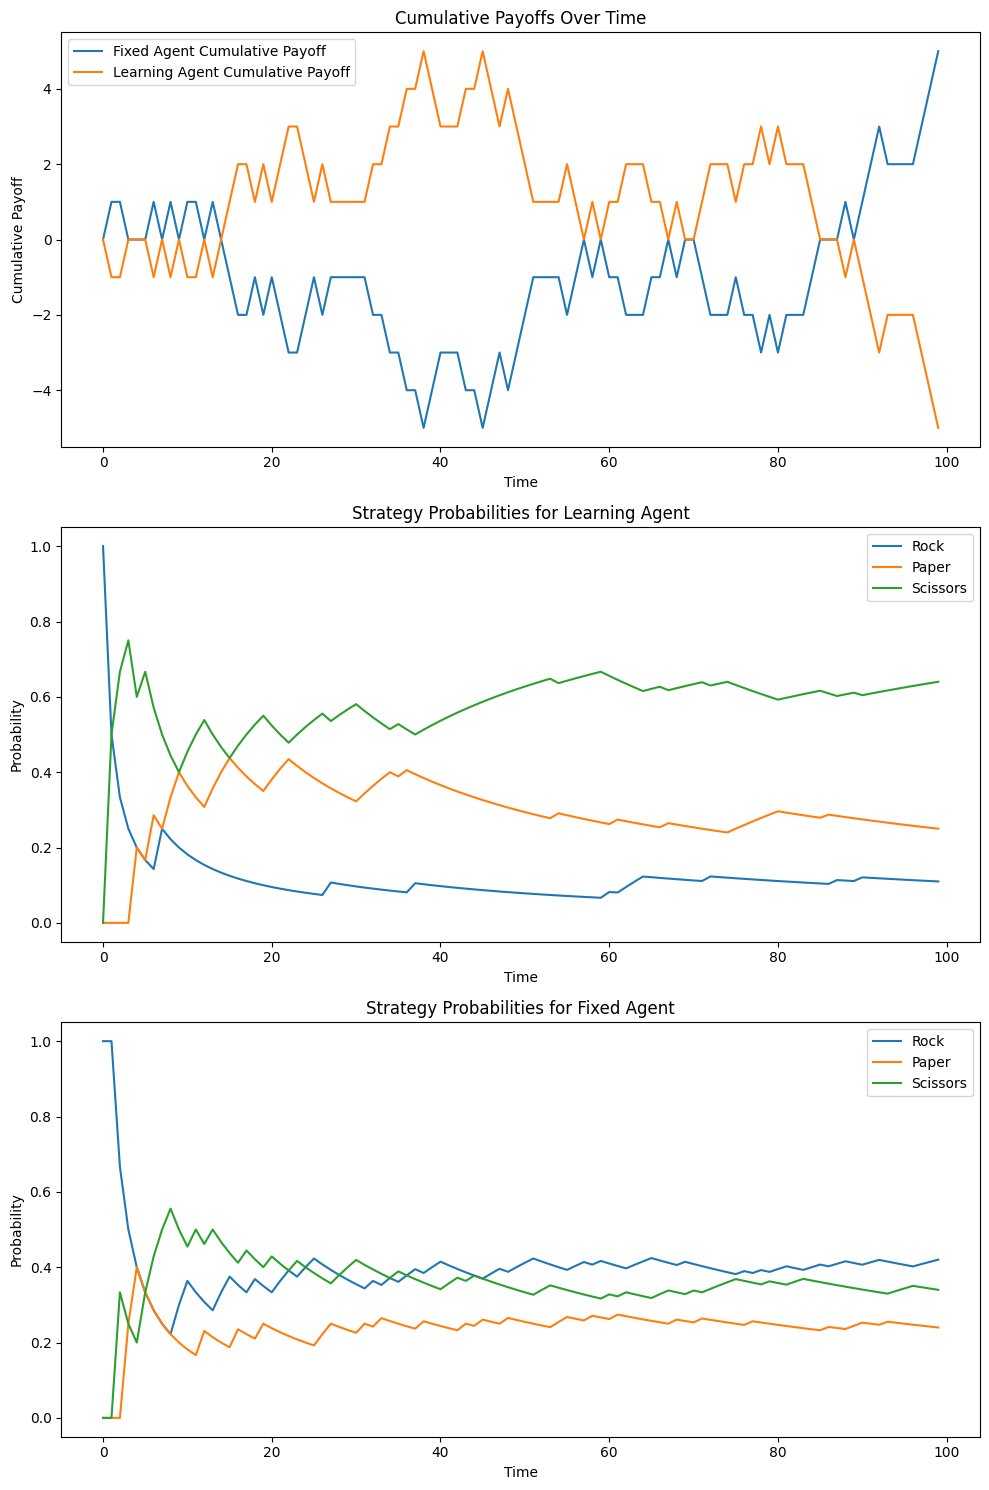

In [11]:
# Initialize agents
fixed_agent = FixedAgent(initial_probs)
learning_agent = LearningAgent(initial_probs, learning_rate)

# Play the game for T periods
for t in range(T):
    action_fixed = fixed_agent.select_action()
    action_learning = learning_agent.select_action()
    fixed_agent.update_strategy(action_learning, action_fixed)
    learning_agent.update_strategy(action_fixed, action_learning)

# Retrieve history
history_fixed = fixed_agent.get_history()
history_learning = learning_agent.get_history()

# Plotting results
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot payoffs
payoffs_fixed = history_fixed[:, 2]
payoffs_learning = history_learning[:, 2]
axs[0].plot(range(T), np.cumsum(payoffs_fixed), label='Fixed Agent Cumulative Payoff')
axs[0].plot(range(T), np.cumsum(payoffs_learning), label='Learning Agent Cumulative Payoff')
axs[0].set_title('Cumulative Payoffs Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Cumulative Payoff')
axs[0].legend()

# Plot strategy probabilities for Learning Agent
prob_rock = [np.mean([h[0] == 0 for h in history_learning[:i+1]]) for i in range(T)]
prob_paper = [np.mean([h[0] == 1 for h in history_learning[:i+1]]) for i in range(T)]
prob_scissors = [np.mean([h[0] == 2 for h in history_learning[:i+1]]) for i in range(T)]
axs[1].plot(range(T), prob_rock, label='Rock')
axs[1].plot(range(T), prob_paper, label='Paper')
axs[1].plot(range(T), prob_scissors, label='Scissors')
axs[1].set_title('Strategy Probabilities for Learning Agent')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Probability')
axs[1].legend()

# Plot strategy probabilities for Fixed Agent
prob_rock_fixed = [np.mean([h[0] == 0 for h in history_fixed[:i+1]]) for i in range(T)]
prob_paper_fixed = [np.mean([h[0] == 1 for h in history_fixed[:i+1]]) for i in range(T)]
prob_scissors_fixed = [np.mean([h[0] == 2 for h in history_fixed[:i+1]]) for i in range(T)]
axs[2].plot(range(T), prob_rock_fixed, label='Rock')
axs[2].plot(range(T), prob_paper_fixed, label='Paper')
axs[2].plot(range(T), prob_scissors_fixed, label='Scissors')
axs[2].set_title('Strategy Probabilities for Fixed Agent')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Probability')
axs[2].legend()

plt.tight_layout()
plt.show()

# Дилемма заключённого в экономической интерпритации

In [57]:
class EconomicAgent:
    def __init__(self, initial_probs, learning_rate=0.01):
        self.probs = np.array(initial_probs)
        self.learning_rate = learning_rate
        self.history = []

    def select_action(self):
        return np.random.choice([0, 1], p=self.probs)

    def update_strategy(self, opponent_action, my_action):
        payoff_matrix = np.array([[100, -300],
                                  [ 300, -150]])

        payoff = payoff_matrix[my_action, opponent_action]
        self.history.append((my_action, opponent_action, payoff))

        grad = -payoff_matrix[:, opponent_action]
        self.probs = self.probs + self.learning_rate * grad

        # Ensure probabilities remain valid
        self.probs = np.clip(self.probs, 0, 1)
        if self.probs.sum() == 0:
            self.probs = np.array([0.5, 0.5])
        else:
            self.probs /= self.probs.sum()

    def get_history(self):
        return np.array(self.history)

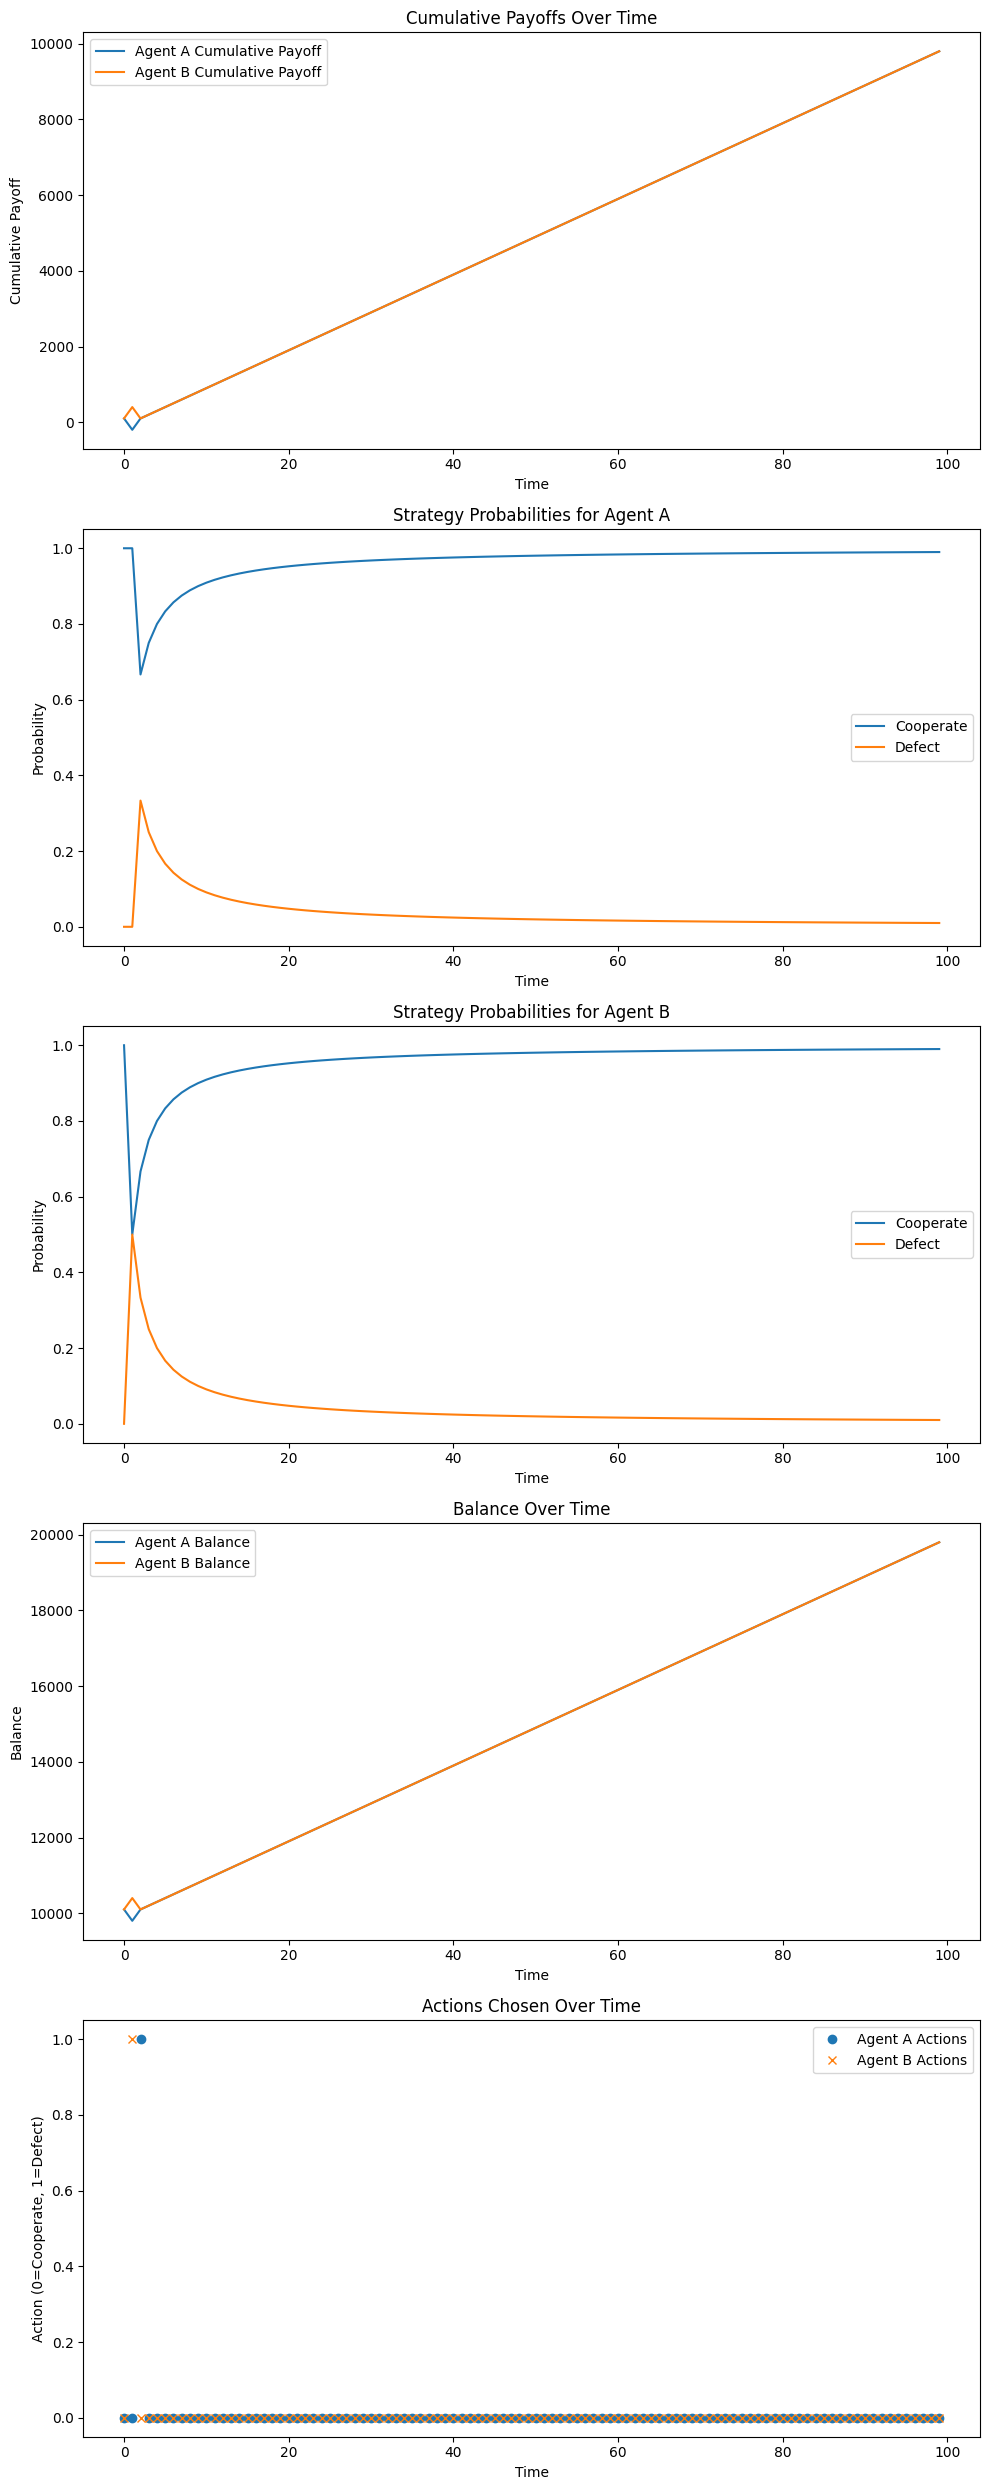

In [73]:
# Parameters
initial_probs = [0.5, 0.5]  # Start with equal probabilities for both actions
learning_rate = 0.001
T = 100  # Number of time periods

# Initialize agents
agent_A = EconomicAgent([0.5, 0.5], learning_rate)
agent_B = EconomicAgent([0.5, 0.5], learning_rate)

# Play the game for T periods
for t in range(T):
    action_A = agent_A.select_action()
    action_B = agent_B.select_action()
    agent_A.update_strategy(action_B, action_A)
    agent_B.update_strategy(action_A, action_B)

# Retrieve history
history_A = agent_A.get_history()
history_B = agent_B.get_history()

# Calculate cumulative payoffs (positive payoffs are gains, negative payoffs are losses)
cumulative_payoff_A = np.cumsum(history_A[:, 2])
cumulative_payoff_B = np.cumsum(history_B[:, 2])

# Calculate balance (initial money plus cumulative payoffs)
initial_money = 10000  # Example initial money for each agent
balance_A = initial_money + cumulative_payoff_A
balance_B = initial_money + cumulative_payoff_B

# Plotting results
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# Plot cumulative payoffs
payoffs_A = history_A[:, 2]
payoffs_B = history_B[:, 2]
axs[0].plot(range(T), cumulative_payoff_A, label='Agent A Cumulative Payoff')
axs[0].plot(range(T), cumulative_payoff_B, label='Agent B Cumulative Payoff')
axs[0].set_title('Cumulative Payoffs Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Cumulative Payoff')
axs[0].legend()

# Plot strategy probabilities for Agent A
prob_cooperate_A = [np.mean([h[0] == 0 for h in history_A[:i+1]]) for i in range(T)]
prob_defect_A = [np.mean([h[0] == 1 for h in history_A[:i+1]]) for i in range(T)]
axs[1].plot(range(T), prob_cooperate_A, label='Cooperate')
axs[1].plot(range(T), prob_defect_A, label='Defect')
axs[1].set_title('Strategy Probabilities for Agent A')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Probability')
axs[1].legend()

# Plot strategy probabilities for Agent B
prob_cooperate_B = [np.mean([h[0] == 0 for h in history_B[:i+1]]) for i in range(T)]
prob_defect_B = [np.mean([h[0] == 1 for h in history_B[:i+1]]) for i in range(T)]
axs[2].plot(range(T), prob_cooperate_B, label='Cooperate')
axs[2].plot(range(T), prob_defect_B, label='Defect')
axs[2].set_title('Strategy Probabilities for Agent B')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Probability')
axs[2].legend()

# Plot balance (earned money) for each agent
axs[3].plot(range(T), balance_A, label='Agent A Balance')
axs[3].plot(range(T), balance_B, label='Agent B Balance')
axs[3].set_title('Balance Over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Balance')
axs[3].legend()

# Plot actions chosen by agents over time
actions_A = history_A[:, 0]
actions_B = history_B[:, 0]
axs[4].plot(range(T), actions_A, label='Agent A Actions', marker='o', linestyle='none')
axs[4].plot(range(T), actions_B, label='Agent B Actions', marker='x', linestyle='none')
axs[4].set_title('Actions Chosen Over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Action (0=Cooperate, 1=Defect)')
axs[4].legend()

plt.tight_layout()
plt.show()

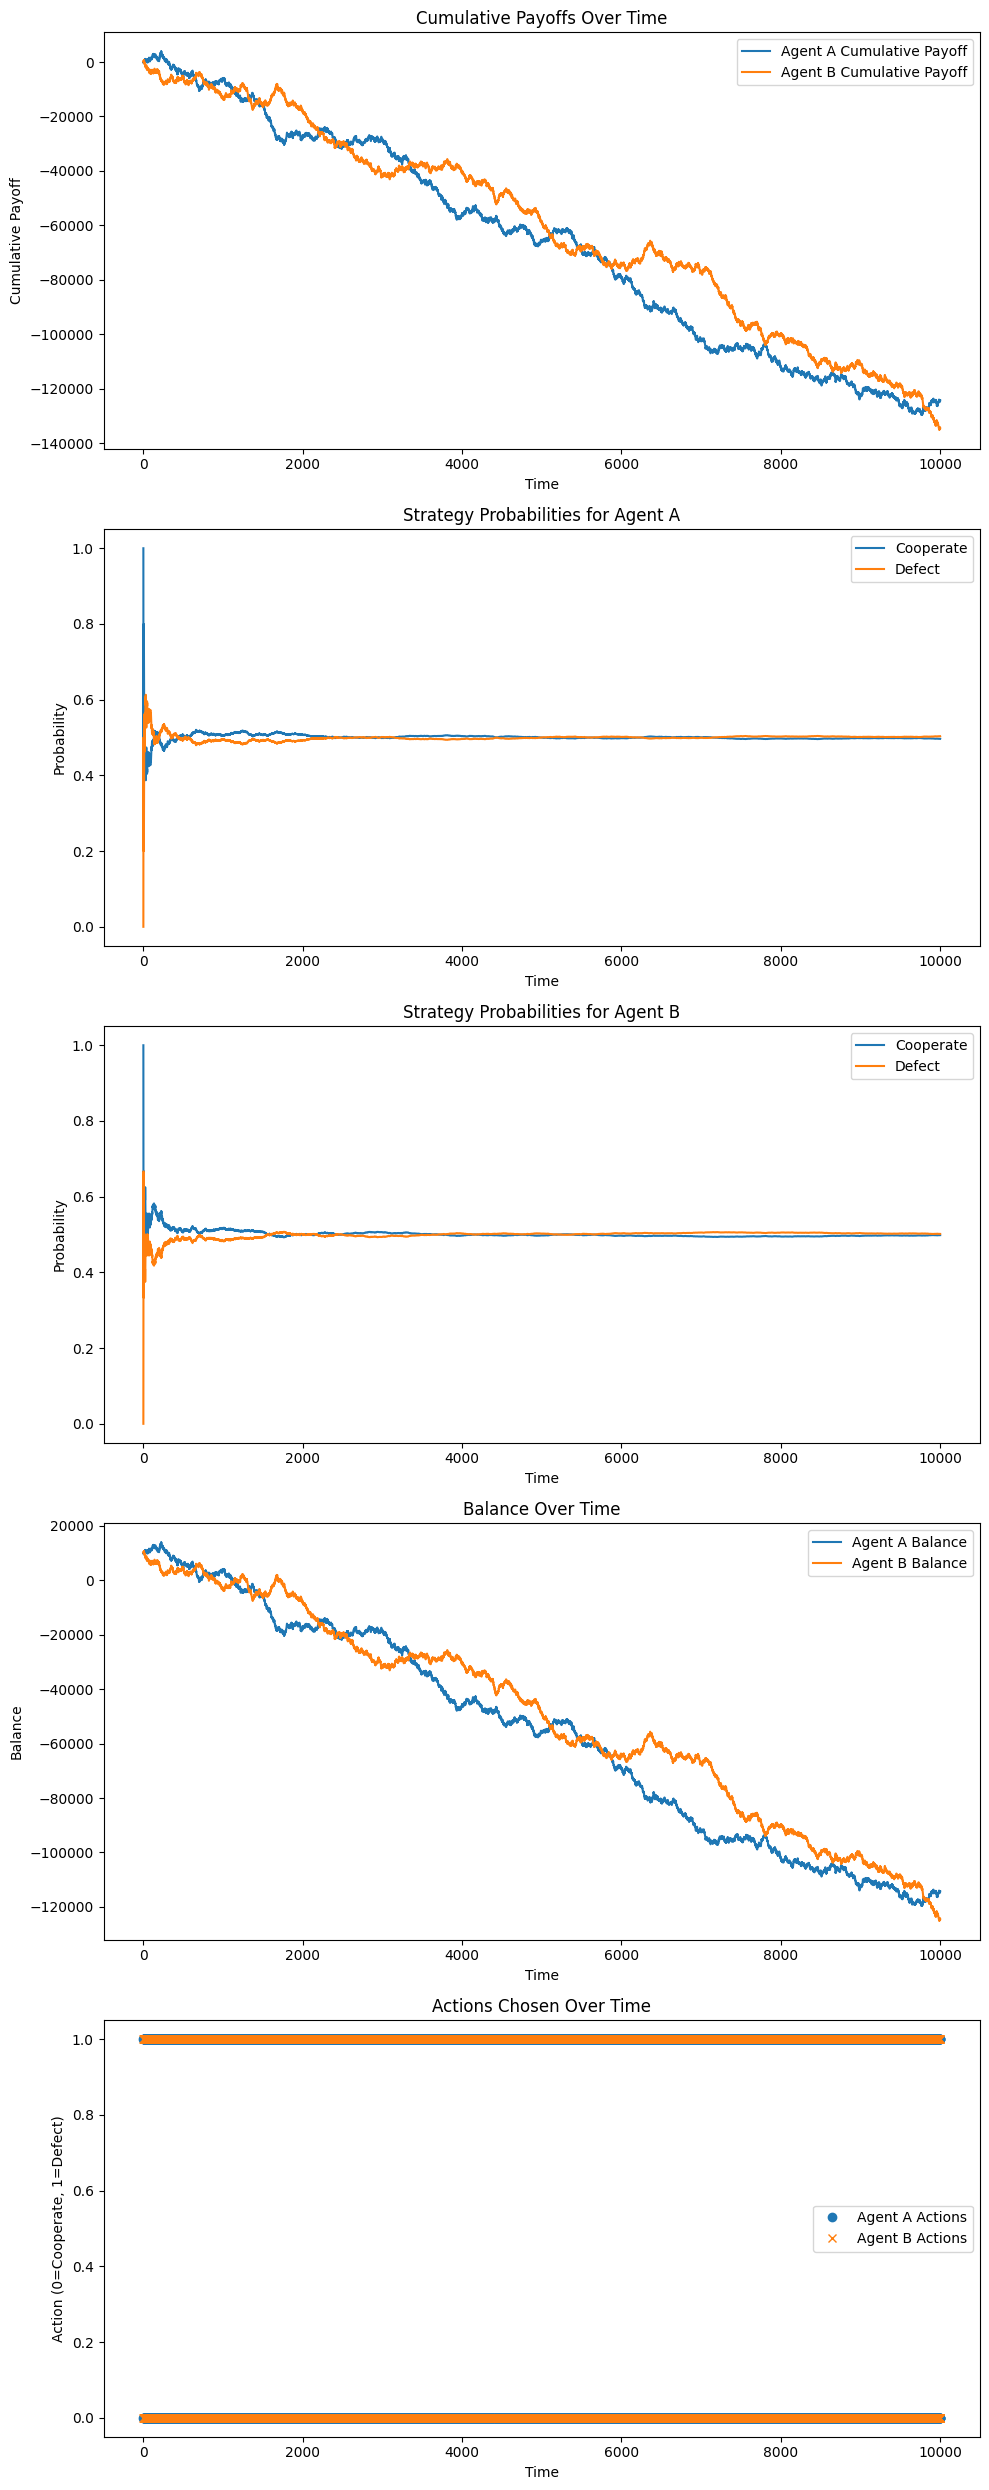

In [75]:
# Parameters
initial_probs = [0.5, 0.5]  # Start with equal probabilities for both actions
learning_rate = 0.01
T = 10000  # Number of time periods

# Initialize agents
agent_A = EconomicAgent([0.5, 0.5], learning_rate)
agent_B = EconomicAgent([0.5, 0.5], learning_rate)

# Play the game for T periods
for t in range(T):
    action_A = agent_A.select_action()
    action_B = agent_B.select_action()
    agent_A.update_strategy(action_B, action_A)
    agent_B.update_strategy(action_A, action_B)

# Retrieve history
history_A = agent_A.get_history()
history_B = agent_B.get_history()

# Calculate cumulative payoffs (positive payoffs are gains, negative payoffs are losses)
cumulative_payoff_A = np.cumsum(history_A[:, 2])
cumulative_payoff_B = np.cumsum(history_B[:, 2])

# Calculate balance (initial money plus cumulative payoffs)
initial_money = 10000  # Example initial money for each agent
balance_A = initial_money + cumulative_payoff_A
balance_B = initial_money + cumulative_payoff_B

# Plotting results
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# Plot cumulative payoffs
payoffs_A = history_A[:, 2]
payoffs_B = history_B[:, 2]
axs[0].plot(range(T), cumulative_payoff_A, label='Agent A Cumulative Payoff')
axs[0].plot(range(T), cumulative_payoff_B, label='Agent B Cumulative Payoff')
axs[0].set_title('Cumulative Payoffs Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Cumulative Payoff')
axs[0].legend()

# Plot strategy probabilities for Agent A
prob_cooperate_A = [np.mean([h[0] == 0 for h in history_A[:i+1]]) for i in range(T)]
prob_defect_A = [np.mean([h[0] == 1 for h in history_A[:i+1]]) for i in range(T)]
axs[1].plot(range(T), prob_cooperate_A, label='Cooperate')
axs[1].plot(range(T), prob_defect_A, label='Defect')
axs[1].set_title('Strategy Probabilities for Agent A')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Probability')
axs[1].legend()

# Plot strategy probabilities for Agent B
prob_cooperate_B = [np.mean([h[0] == 0 for h in history_B[:i+1]]) for i in range(T)]
prob_defect_B = [np.mean([h[0] == 1 for h in history_B[:i+1]]) for i in range(T)]
axs[2].plot(range(T), prob_cooperate_B, label='Cooperate')
axs[2].plot(range(T), prob_defect_B, label='Defect')
axs[2].set_title('Strategy Probabilities for Agent B')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Probability')
axs[2].legend()

# Plot balance (earned money) for each agent
axs[3].plot(range(T), balance_A, label='Agent A Balance')
axs[3].plot(range(T), balance_B, label='Agent B Balance')
axs[3].set_title('Balance Over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Balance')
axs[3].legend()

# Plot actions chosen by agents over time
actions_A = history_A[:, 0]
actions_B = history_B[:, 0]
axs[4].plot(range(T), actions_A, label='Agent A Actions', marker='o', linestyle='none')
axs[4].plot(range(T), actions_B, label='Agent B Actions', marker='x', linestyle='none')
axs[4].set_title('Actions Chosen Over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Action (0=Cooperate, 1=Defect)')
axs[4].legend()

plt.tight_layout()
plt.show()

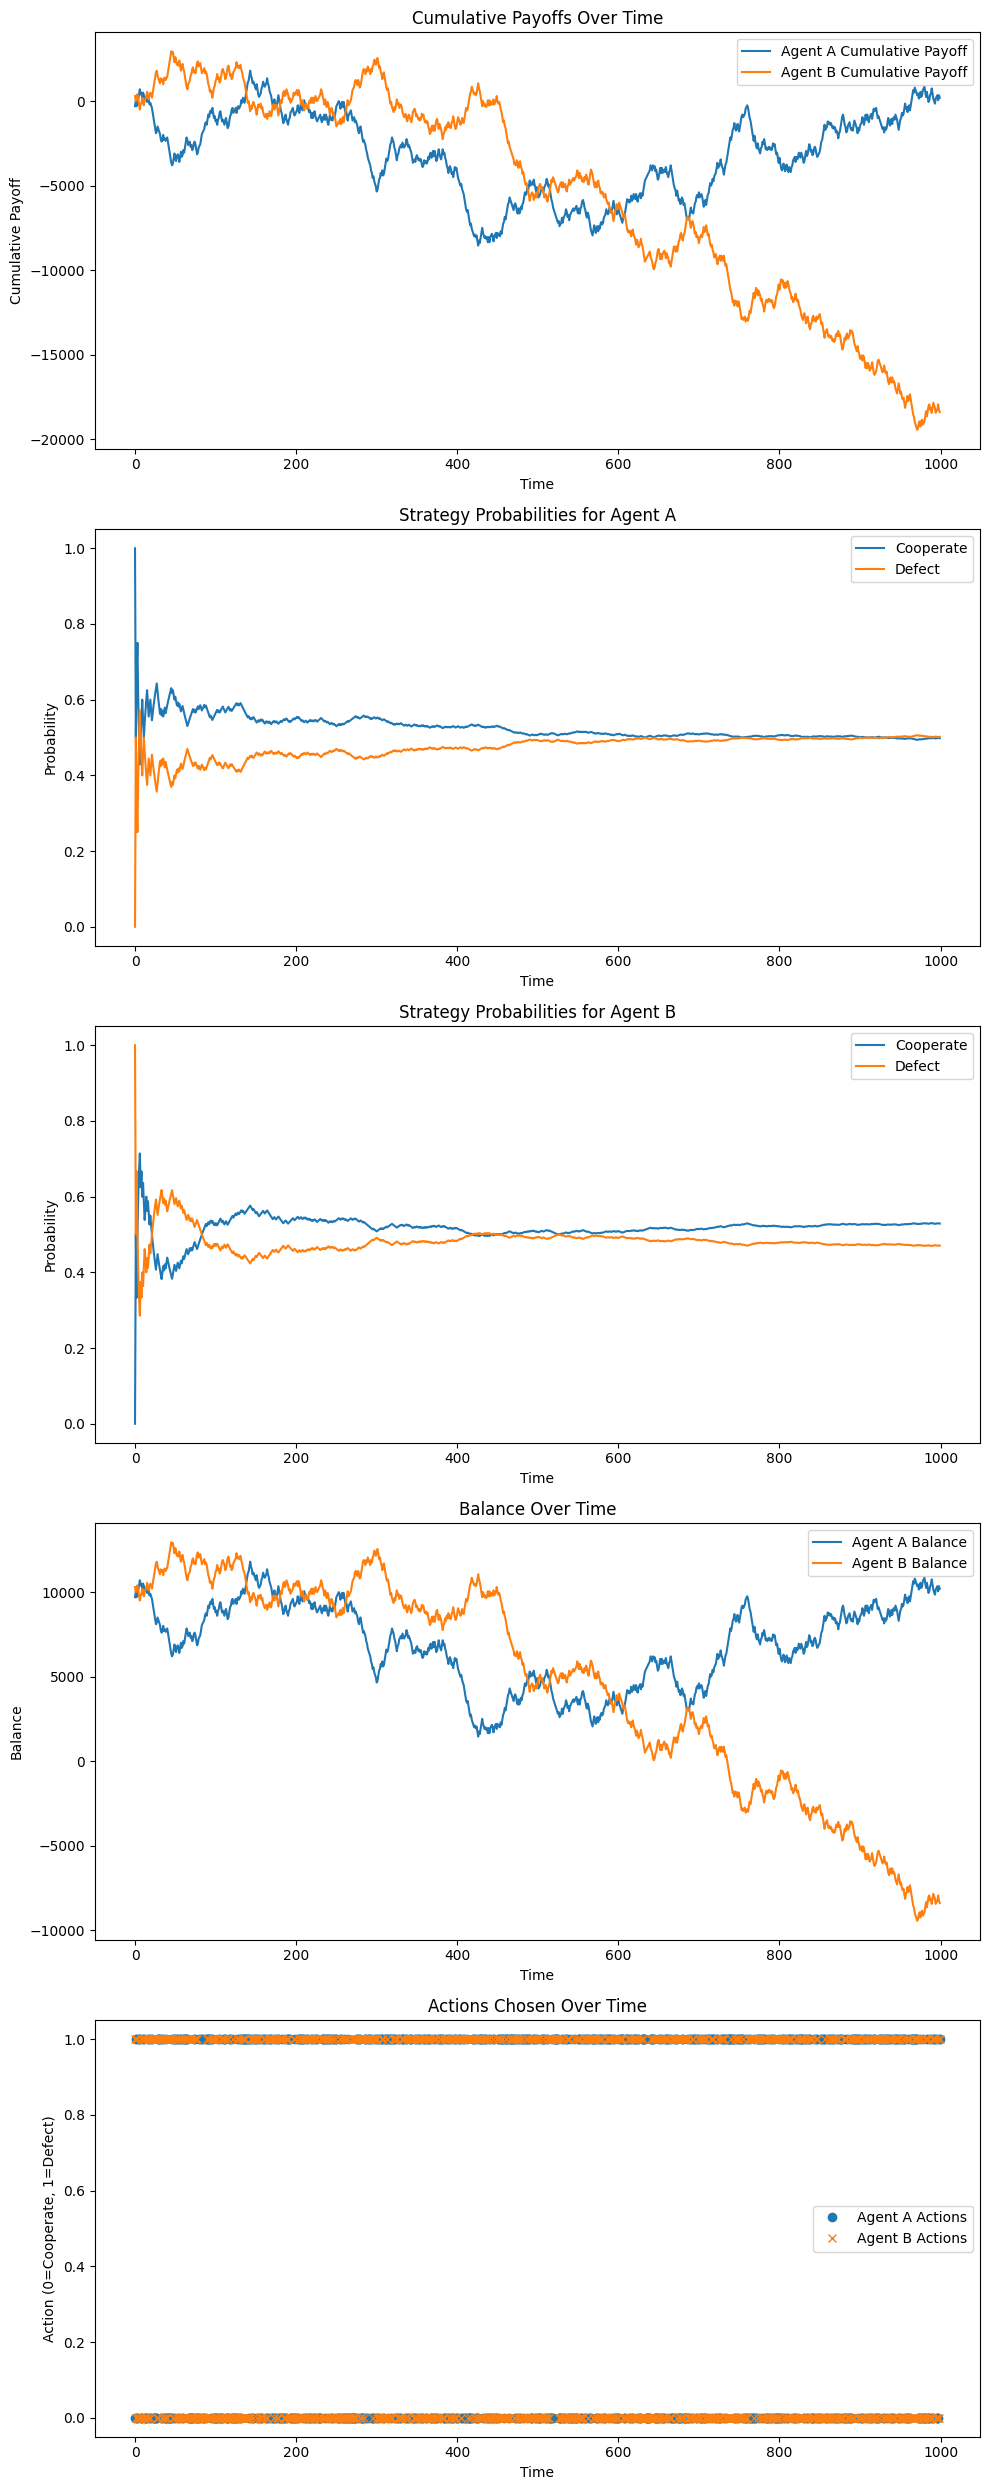

In [77]:
# Parameters
initial_probs = [0.5, 0.5]  # Start with equal probabilities for both actions
learning_rate = 0.1
T = 1000  # Number of time periods

# Initialize agents
agent_A = EconomicAgent([0.5, 0.5], learning_rate)
agent_B = EconomicAgent([0.5, 0.5], learning_rate)

# Play the game for T periods
for t in range(T):
    action_A = agent_A.select_action()
    action_B = agent_B.select_action()
    agent_A.update_strategy(action_B, action_A)
    agent_B.update_strategy(action_A, action_B)

# Retrieve history
history_A = agent_A.get_history()
history_B = agent_B.get_history()

# Calculate cumulative payoffs (positive payoffs are gains, negative payoffs are losses)
cumulative_payoff_A = np.cumsum(history_A[:, 2])
cumulative_payoff_B = np.cumsum(history_B[:, 2])

# Calculate balance (initial money plus cumulative payoffs)
initial_money = 10000  # Example initial money for each agent
balance_A = initial_money + cumulative_payoff_A
balance_B = initial_money + cumulative_payoff_B

# Plotting results
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# Plot cumulative payoffs
payoffs_A = history_A[:, 2]
payoffs_B = history_B[:, 2]
axs[0].plot(range(T), cumulative_payoff_A, label='Agent A Cumulative Payoff')
axs[0].plot(range(T), cumulative_payoff_B, label='Agent B Cumulative Payoff')
axs[0].set_title('Cumulative Payoffs Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Cumulative Payoff')
axs[0].legend()

# Plot strategy probabilities for Agent A
prob_cooperate_A = [np.mean([h[0] == 0 for h in history_A[:i+1]]) for i in range(T)]
prob_defect_A = [np.mean([h[0] == 1 for h in history_A[:i+1]]) for i in range(T)]
axs[1].plot(range(T), prob_cooperate_A, label='Cooperate')
axs[1].plot(range(T), prob_defect_A, label='Defect')
axs[1].set_title('Strategy Probabilities for Agent A')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Probability')
axs[1].legend()

# Plot strategy probabilities for Agent B
prob_cooperate_B = [np.mean([h[0] == 0 for h in history_B[:i+1]]) for i in range(T)]
prob_defect_B = [np.mean([h[0] == 1 for h in history_B[:i+1]]) for i in range(T)]
axs[2].plot(range(T), prob_cooperate_B, label='Cooperate')
axs[2].plot(range(T), prob_defect_B, label='Defect')
axs[2].set_title('Strategy Probabilities for Agent B')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Probability')
axs[2].legend()

# Plot balance (earned money) for each agent
axs[3].plot(range(T), balance_A, label='Agent A Balance')
axs[3].plot(range(T), balance_B, label='Agent B Balance')
axs[3].set_title('Balance Over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Balance')
axs[3].legend()

# Plot actions chosen by agents over time
actions_A = history_A[:, 0]
actions_B = history_B[:, 0]
axs[4].plot(range(T), actions_A, label='Agent A Actions', marker='o', linestyle='none')
axs[4].plot(range(T), actions_B, label='Agent B Actions', marker='x', linestyle='none')
axs[4].set_title('Actions Chosen Over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Action (0=Cooperate, 1=Defect)')
axs[4].legend()

plt.tight_layout()
plt.show()

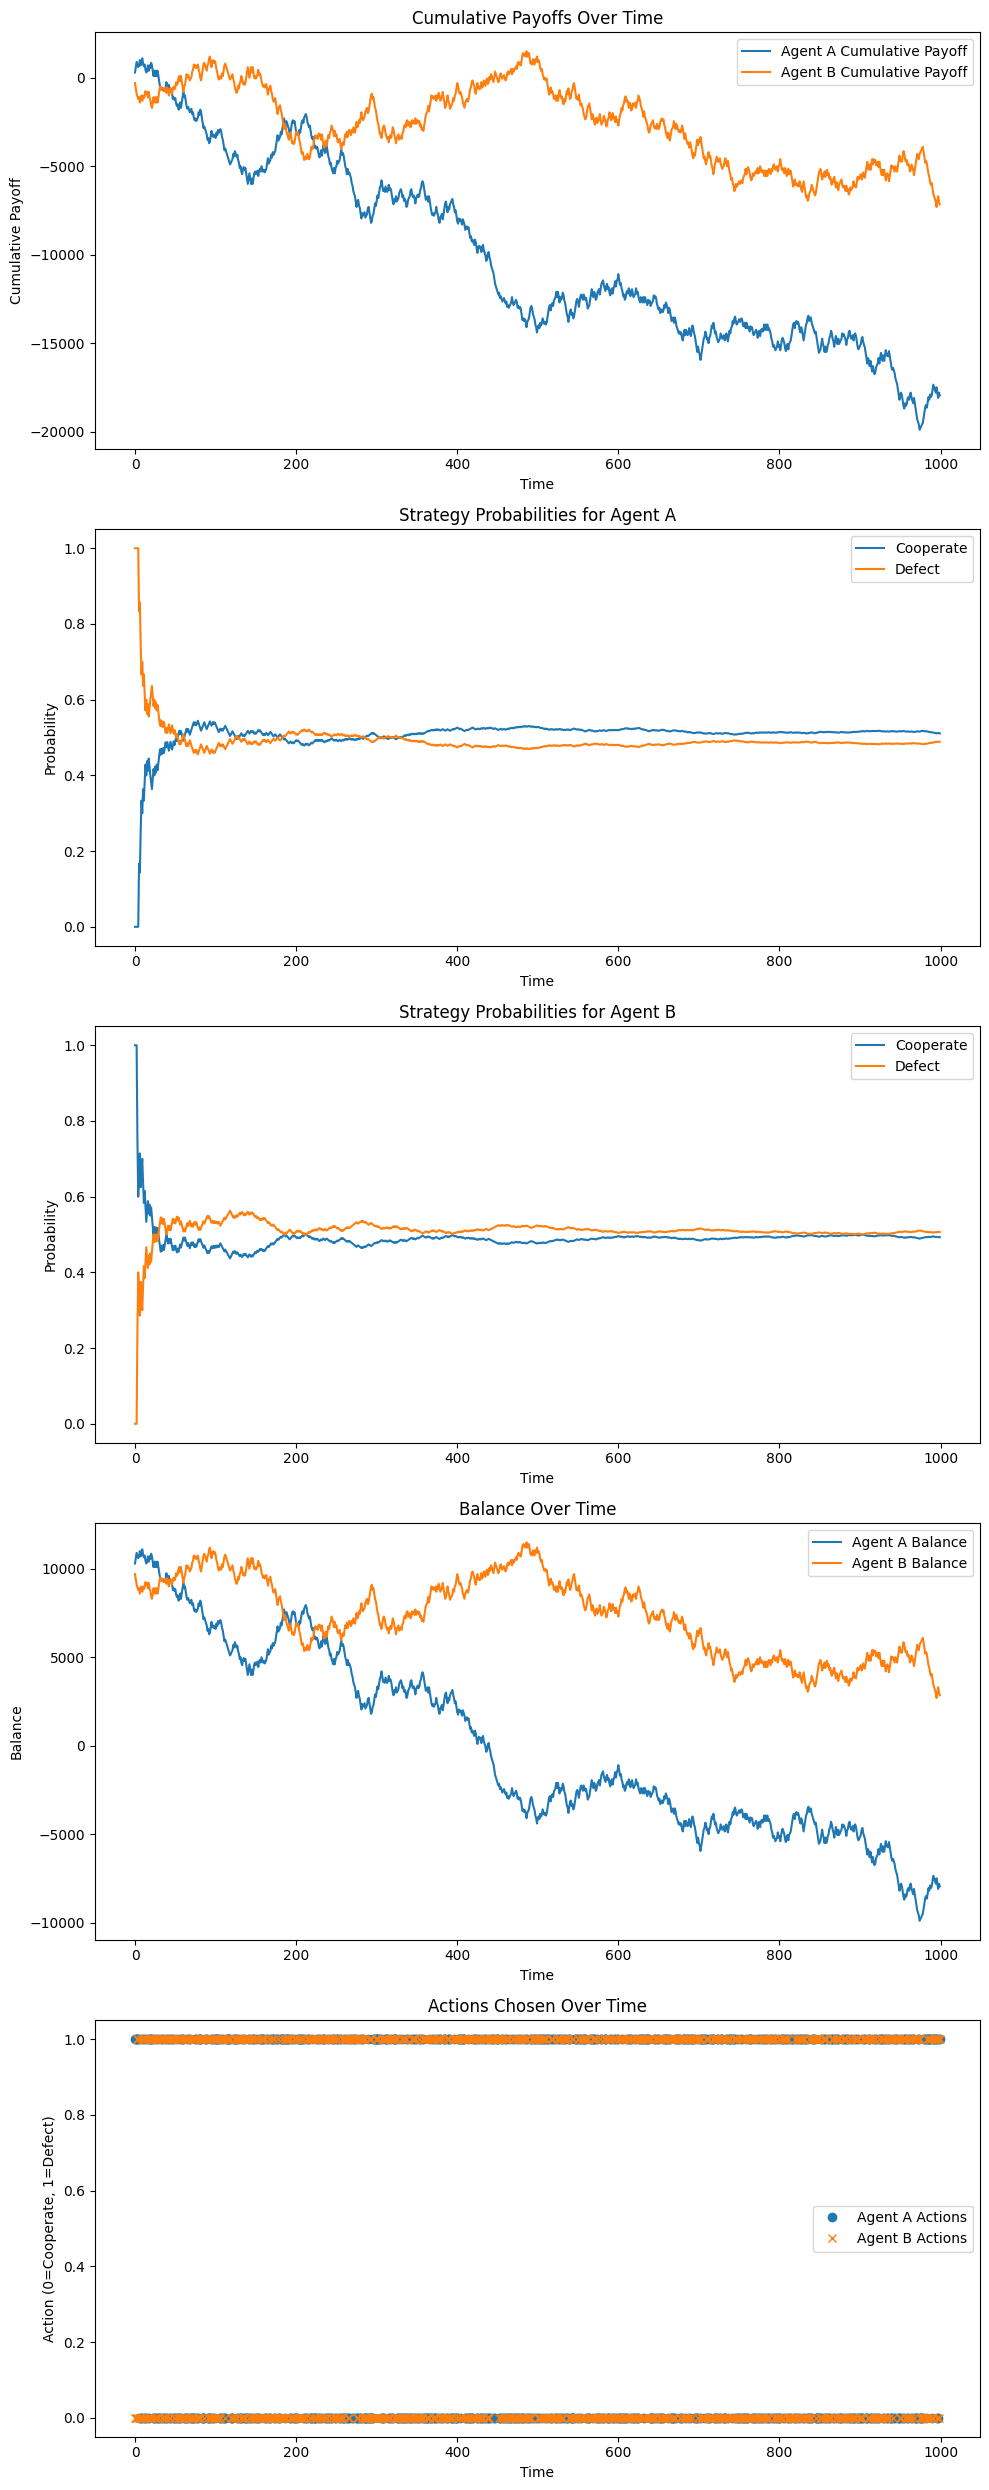

In [78]:
# Parameters
initial_probs = [0.5, 0.5]  # Start with equal probabilities for both actions
learning_rate = 1
T = 1000  # Number of time periods

# Initialize agents
agent_A = EconomicAgent([0.5, 0.5], learning_rate)
agent_B = EconomicAgent([0.5, 0.5], learning_rate)

# Play the game for T periods
for t in range(T):
    action_A = agent_A.select_action()
    action_B = agent_B.select_action()
    agent_A.update_strategy(action_B, action_A)
    agent_B.update_strategy(action_A, action_B)

# Retrieve history
history_A = agent_A.get_history()
history_B = agent_B.get_history()

# Calculate cumulative payoffs (positive payoffs are gains, negative payoffs are losses)
cumulative_payoff_A = np.cumsum(history_A[:, 2])
cumulative_payoff_B = np.cumsum(history_B[:, 2])

# Calculate balance (initial money plus cumulative payoffs)
initial_money = 10000  # Example initial money for each agent
balance_A = initial_money + cumulative_payoff_A
balance_B = initial_money + cumulative_payoff_B

# Plotting results
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# Plot cumulative payoffs
payoffs_A = history_A[:, 2]
payoffs_B = history_B[:, 2]
axs[0].plot(range(T), cumulative_payoff_A, label='Agent A Cumulative Payoff')
axs[0].plot(range(T), cumulative_payoff_B, label='Agent B Cumulative Payoff')
axs[0].set_title('Cumulative Payoffs Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Cumulative Payoff')
axs[0].legend()

# Plot strategy probabilities for Agent A
prob_cooperate_A = [np.mean([h[0] == 0 for h in history_A[:i+1]]) for i in range(T)]
prob_defect_A = [np.mean([h[0] == 1 for h in history_A[:i+1]]) for i in range(T)]
axs[1].plot(range(T), prob_cooperate_A, label='Cooperate')
axs[1].plot(range(T), prob_defect_A, label='Defect')
axs[1].set_title('Strategy Probabilities for Agent A')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Probability')
axs[1].legend()

# Plot strategy probabilities for Agent B
prob_cooperate_B = [np.mean([h[0] == 0 for h in history_B[:i+1]]) for i in range(T)]
prob_defect_B = [np.mean([h[0] == 1 for h in history_B[:i+1]]) for i in range(T)]
axs[2].plot(range(T), prob_cooperate_B, label='Cooperate')
axs[2].plot(range(T), prob_defect_B, label='Defect')
axs[2].set_title('Strategy Probabilities for Agent B')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Probability')
axs[2].legend()

# Plot balance (earned money) for each agent
axs[3].plot(range(T), balance_A, label='Agent A Balance')
axs[3].plot(range(T), balance_B, label='Agent B Balance')
axs[3].set_title('Balance Over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Balance')
axs[3].legend()

# Plot actions chosen by agents over time
actions_A = history_A[:, 0]
actions_B = history_B[:, 0]
axs[4].plot(range(T), actions_A, label='Agent A Actions', marker='o', linestyle='none')
axs[4].plot(range(T), actions_B, label='Agent B Actions', marker='x', linestyle='none')
axs[4].set_title('Actions Chosen Over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Action (0=Cooperate, 1=Defect)')
axs[4].legend()

plt.tight_layout()
plt.show()

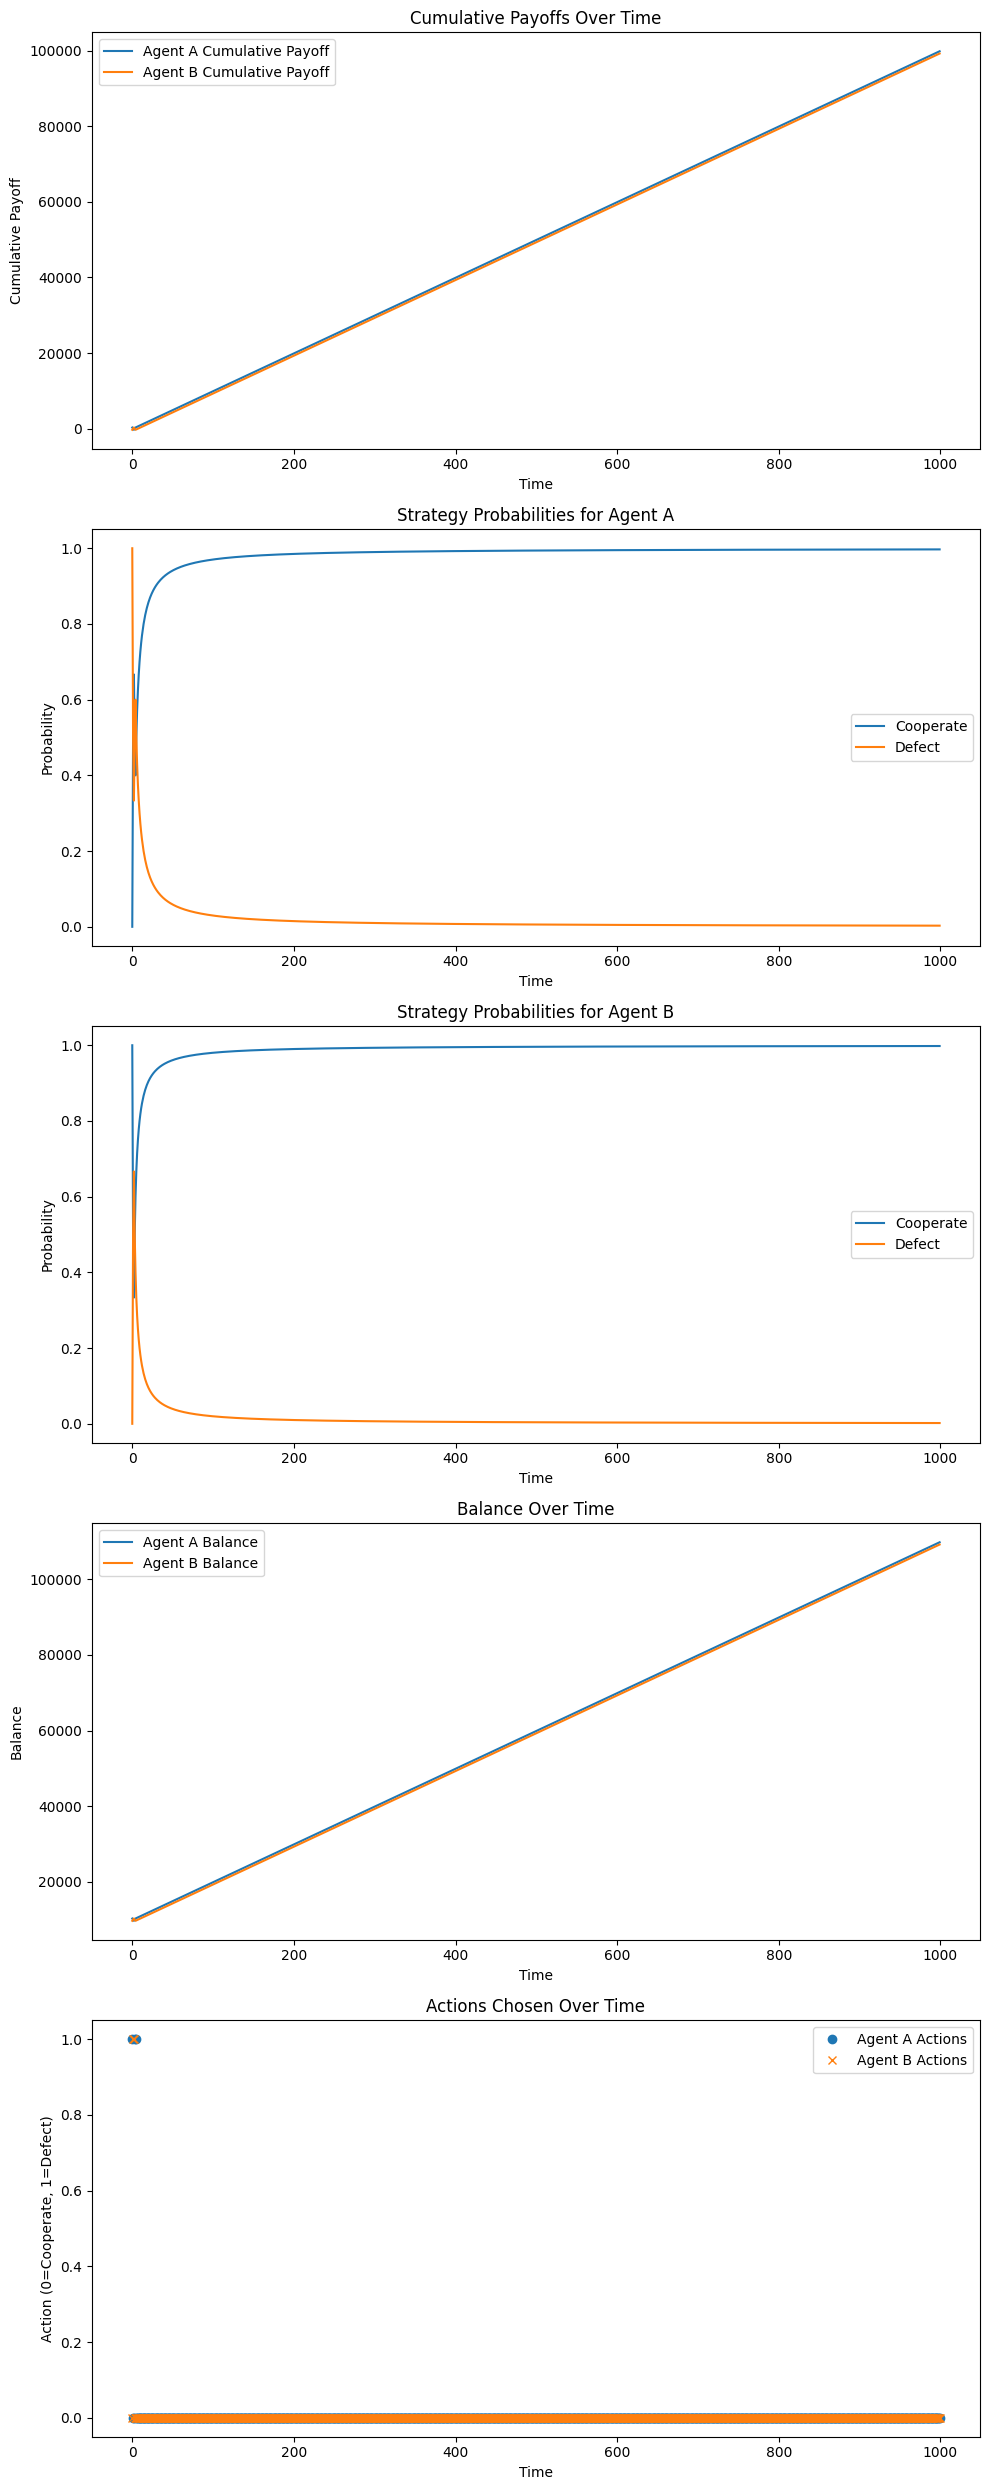

In [79]:
# Parameters
initial_probs = [0.5, 0.5]  # Start with equal probabilities for both actions
learning_rate = 0.001
T = 1000  # Number of time periods

# Initialize agents
agent_A = EconomicAgent([0.5, 0.5], learning_rate)
agent_B = EconomicAgent([0.5, 0.5], learning_rate)

# Play the game for T periods
for t in range(T):
    action_A = agent_A.select_action()
    action_B = agent_B.select_action()
    agent_A.update_strategy(action_B, action_A)
    agent_B.update_strategy(action_A, action_B)

# Retrieve history
history_A = agent_A.get_history()
history_B = agent_B.get_history()

# Calculate cumulative payoffs (positive payoffs are gains, negative payoffs are losses)
cumulative_payoff_A = np.cumsum(history_A[:, 2])
cumulative_payoff_B = np.cumsum(history_B[:, 2])

# Calculate balance (initial money plus cumulative payoffs)
initial_money = 10000  # Example initial money for each agent
balance_A = initial_money + cumulative_payoff_A
balance_B = initial_money + cumulative_payoff_B

# Plotting results
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# Plot cumulative payoffs
payoffs_A = history_A[:, 2]
payoffs_B = history_B[:, 2]
axs[0].plot(range(T), cumulative_payoff_A, label='Agent A Cumulative Payoff')
axs[0].plot(range(T), cumulative_payoff_B, label='Agent B Cumulative Payoff')
axs[0].set_title('Cumulative Payoffs Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Cumulative Payoff')
axs[0].legend()

# Plot strategy probabilities for Agent A
prob_cooperate_A = [np.mean([h[0] == 0 for h in history_A[:i+1]]) for i in range(T)]
prob_defect_A = [np.mean([h[0] == 1 for h in history_A[:i+1]]) for i in range(T)]
axs[1].plot(range(T), prob_cooperate_A, label='Cooperate')
axs[1].plot(range(T), prob_defect_A, label='Defect')
axs[1].set_title('Strategy Probabilities for Agent A')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Probability')
axs[1].legend()

# Plot strategy probabilities for Agent B
prob_cooperate_B = [np.mean([h[0] == 0 for h in history_B[:i+1]]) for i in range(T)]
prob_defect_B = [np.mean([h[0] == 1 for h in history_B[:i+1]]) for i in range(T)]
axs[2].plot(range(T), prob_cooperate_B, label='Cooperate')
axs[2].plot(range(T), prob_defect_B, label='Defect')
axs[2].set_title('Strategy Probabilities for Agent B')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Probability')
axs[2].legend()

# Plot balance (earned money) for each agent
axs[3].plot(range(T), balance_A, label='Agent A Balance')
axs[3].plot(range(T), balance_B, label='Agent B Balance')
axs[3].set_title('Balance Over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Balance')
axs[3].legend()

# Plot actions chosen by agents over time
actions_A = history_A[:, 0]
actions_B = history_B[:, 0]
axs[4].plot(range(T), actions_A, label='Agent A Actions', marker='o', linestyle='none')
axs[4].plot(range(T), actions_B, label='Agent B Actions', marker='x', linestyle='none')
axs[4].set_title('Actions Chosen Over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Action (0=Cooperate, 1=Defect)')
axs[4].legend()

plt.tight_layout()
plt.show()

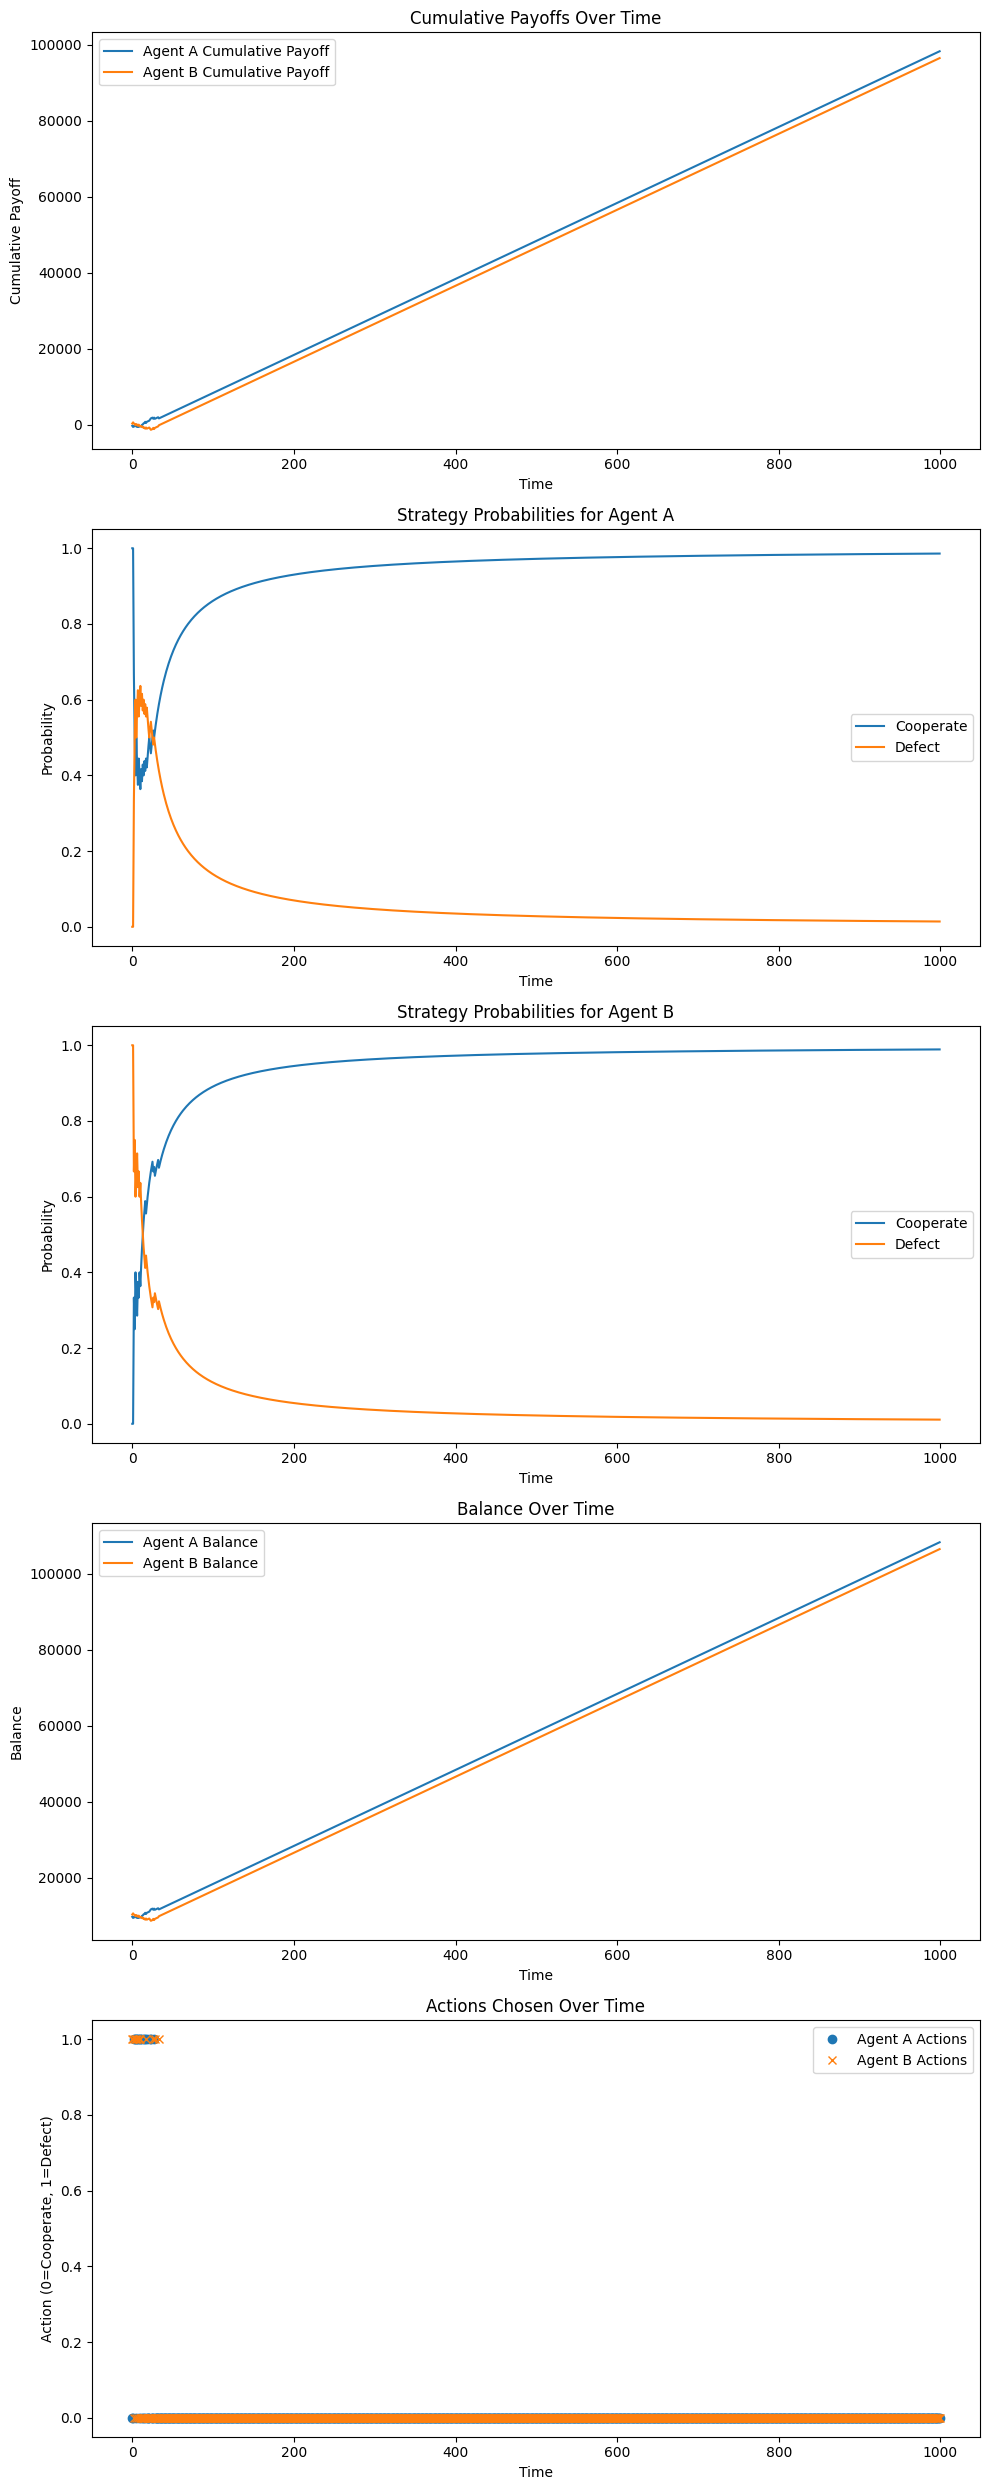

In [80]:
# Parameters
initial_probs = [0.5, 0.5]  # Start with equal probabilities for both actions
learning_rate = 0.0001
T = 1000  # Number of time periods

# Initialize agents
agent_A = EconomicAgent([0.5, 0.5], learning_rate)
agent_B = EconomicAgent([0.5, 0.5], learning_rate)

# Play the game for T periods
for t in range(T):
    action_A = agent_A.select_action()
    action_B = agent_B.select_action()
    agent_A.update_strategy(action_B, action_A)
    agent_B.update_strategy(action_A, action_B)

# Retrieve history
history_A = agent_A.get_history()
history_B = agent_B.get_history()

# Calculate cumulative payoffs (positive payoffs are gains, negative payoffs are losses)
cumulative_payoff_A = np.cumsum(history_A[:, 2])
cumulative_payoff_B = np.cumsum(history_B[:, 2])

# Calculate balance (initial money plus cumulative payoffs)
initial_money = 10000  # Example initial money for each agent
balance_A = initial_money + cumulative_payoff_A
balance_B = initial_money + cumulative_payoff_B

# Plotting results
fig, axs = plt.subplots(5, 1, figsize=(10, 25))

# Plot cumulative payoffs
payoffs_A = history_A[:, 2]
payoffs_B = history_B[:, 2]
axs[0].plot(range(T), cumulative_payoff_A, label='Agent A Cumulative Payoff')
axs[0].plot(range(T), cumulative_payoff_B, label='Agent B Cumulative Payoff')
axs[0].set_title('Cumulative Payoffs Over Time')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Cumulative Payoff')
axs[0].legend()

# Plot strategy probabilities for Agent A
prob_cooperate_A = [np.mean([h[0] == 0 for h in history_A[:i+1]]) for i in range(T)]
prob_defect_A = [np.mean([h[0] == 1 for h in history_A[:i+1]]) for i in range(T)]
axs[1].plot(range(T), prob_cooperate_A, label='Cooperate')
axs[1].plot(range(T), prob_defect_A, label='Defect')
axs[1].set_title('Strategy Probabilities for Agent A')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Probability')
axs[1].legend()

# Plot strategy probabilities for Agent B
prob_cooperate_B = [np.mean([h[0] == 0 for h in history_B[:i+1]]) for i in range(T)]
prob_defect_B = [np.mean([h[0] == 1 for h in history_B[:i+1]]) for i in range(T)]
axs[2].plot(range(T), prob_cooperate_B, label='Cooperate')
axs[2].plot(range(T), prob_defect_B, label='Defect')
axs[2].set_title('Strategy Probabilities for Agent B')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('Probability')
axs[2].legend()

# Plot balance (earned money) for each agent
axs[3].plot(range(T), balance_A, label='Agent A Balance')
axs[3].plot(range(T), balance_B, label='Agent B Balance')
axs[3].set_title('Balance Over Time')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Balance')
axs[3].legend()

# Plot actions chosen by agents over time
actions_A = history_A[:, 0]
actions_B = history_B[:, 0]
axs[4].plot(range(T), actions_A, label='Agent A Actions', marker='o', linestyle='none')
axs[4].plot(range(T), actions_B, label='Agent B Actions', marker='x', linestyle='none')
axs[4].set_title('Actions Chosen Over Time')
axs[4].set_xlabel('Time')
axs[4].set_ylabel('Action (0=Cooperate, 1=Defect)')
axs[4].legend()

plt.tight_layout()
plt.show()